import functools
import manim
import numpy as np
import math

class SceneObjects:
    def __init__(self):
        vec = np.array([1,0])
        self.points = np.array([[4.2, 2.1], [1.2, -0.5], [3.7, 3.5], [-1.1, -0.2], [-1.9, 1.5]])
        self.points_projected = None
        self.update_vec(vec)
        self.dots = self.create_dots()
        
    def update_vec(self, vec):
        self.vec = vec
        self.points_projected = self.project(self.points, self.vec)
    
    @staticmethod
    def project(points, vec):
        scalars = points @ vec.T
        projected_points = scalars[:, np.newaxis] @ vec.T[np.newaxis, :]
        return projected_points
        
    def create_dots(self):
        dots = []
        def reproject_dot(o, i):
            o.move_to([*self.points_projected[i], 0])
        for i,p in enumerate(self.points_projected):
            d = manim.Dot([*p, 0])
            d.add_updater(functools.partial(reproject_dot, i=i))
            dots.append(d)            
        return dots
    
    
class MyScene(manim.Scene):
    def construct(self):
        self.add(manim.NumberPlane())
        scene_objects = SceneObjects()
        self.add(*scene_objects.dots)
        class ProxyAnim(manim.Animation):
            def update_mobjects(self, dt):
                rotate_rate = 0.2
                rotate_rads = dt * rotate_rate
                v_new = scene_objects.vec @ np.array([[math.cos(rotate_rads), math.sin(rotate_rads)],
                                                      [-math.sin(rotate_rads), math.cos(rotate_rads)]])
                scene_objects.update_vec(v_new)
        self.play(ProxyAnim(None))
        self.wait()
            

In [740]:
import numpy as np
import matplotlib.pyplot as plt
import math
import manim
import functools
import copy
from enum import Enum
import sklearn as sk
import sklearn.decomposition as sk_dcomp

Ref  
[Colors](https://www.reddit.com/r/manim/comments/dzxoen/predefined_color_scheme/)

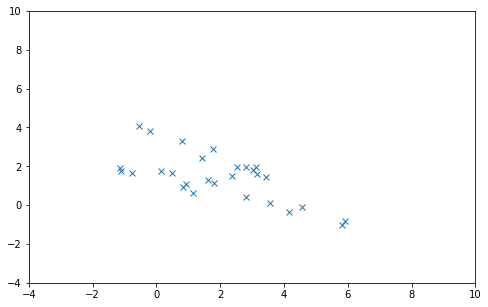

In [138]:
NUM_POINTS_PER_CLASS = 14
NUM_CLASSES = 2
NUM_POINTS = NUM_CLASSES * NUM_POINTS_PER_CLASS

def generate_data():
    seed = 124
    rng = np.random.Generator(np.random.PCG64(seed))
    def transform(points, rotate_rads, offset):
        scale = np.array([[0.25, 0], [0, 2.5]])
        rotate = np.array([[math.cos(rotate_rads), math.sin(rotate_rads)],
                           [-math.sin(rotate_rads), math.cos(rotate_rads)]])
        points = points @ scale
        points = points @ rotate
        points = points + offset
        return points
    points = rng.multivariate_normal([0,0], [[1, 0],[0,1]], size=NUM_POINTS)
    points_c1 = transform(points[:NUM_POINTS//2], 1.2, np.array([1.5, 1]))
    points_c2 = transform(points[NUM_POINTS//2:], 0.9, np.array([2.5, 2]))
    return np.concatenate([points_c1, points_c2], axis=0)

points = generate_data()
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim([-4, 10])
ax.set_xlim([-4, 10])
points.T[0, :]
ax.plot(points.T[0, :], points.T[1, :], 'x')

In [763]:
def project_points(points, vec, progress):
    scalars = points @ vec.T
    projected_points = scalars[:, np.newaxis] @ vec.T[np.newaxis, :]
    interpolated = points - progress * (points - projected_points) 
    return projected_points, interpolated

def vec_to_angle(vec):
    a = np.arctan2(vec[1], vec[0])
    if a < 0:
        a = 2*math.pi + a
    return a

class NumberLineThinTicks(manim.NumberLine):
    def get_tick(self, x, size=None):
        if size is None:
            size = self.tick_size
        result = manim.Line(size * manim.DOWN, size * manim.UP)
        result.rotate(self.get_angle())
        result.move_to(self.number_to_point(x))
        result.match_style(self)
        result.set(stroke_width=3)
        return result    
    
class SceneData:
    def __init__(self, points, vec, progress=0):
        self.points = points
        self.points_projected = None
        self.points_progress = None
        self.vec = vec
        self.progress = progress
        self.update()
        
    def update(self):
        projected, progress =  project_points(self.points, self.vec, self.progress)
        self.points_projected = projected
        self.points_progress = progress
        
    def update_vec(self, vec):
        self.vec = vec
        self.update()
    
    def update_progress(self, progress):
        self.progress = progress
        self.update()
        
        
class SceneObjects:
    def __init__(self, scene_data):
        self.scene_data = scene_data
        self._dot_orig_color = manim.utils.color.WHITE
        self._dot_options =  {'radius':0.08, 'stroke_width':0.5, 'fill_opacity':1.0,
                              'stroke_color':manim.utils.color.BLACK}
        self.dots = self.create_dots()
        self.dots_projected = self.create_projected_dots()
        self.projection_lines = self.create_projection_lines()
        self.vec_arrow = self.create_vec_arrow()
        self.vec_line = self.create_vec_line()
        
    def create_dots(self):
        dots = self.create_stationary_dots()
        for i,d in enumerate(dots):
            def update_dot(i, o):
                o.move_to([*self.scene_data.points_progress[i], 0])
            d.add_updater(functools.partial(update_dot, i))
        return dots
    
    def enable_dull_orig_dots(self, is_enabled):
        color = manim.utils.color.GREY if is_enabled else self._dot_orig_color
        #opacity = 0.5 if is_enabled else 1.0
        for d in self.dots:
            #d.set_color(color)
            d.set_stroke_width(0.0)
   
    def create_stationary_dots(self):
        dots = []
        for i,p in enumerate(self.scene_data.points_progress):
            d = manim.Dot([*p, 0], color=self._dot_orig_color, **self._dot_options)
            dots.append(d)
        return dots

    def create_projected_dots(self):
        dots = []
        dot_options = self._dot_options
        for i,p in enumerate(self.scene_data.points_projected):
            d = manim.Dot([*p, 0], color=manim.utils.color.WHITE, **dot_options)
            def reproject_dot(i, o):
                o.move_to([*self.scene_data.points_projected[i], 0])
            d.add_updater(functools.partial(reproject_dot, i))
            dots.append(d)
        return dots
    
    def create_projection_lines(self):
        lines = []
        if self.scene_data.points.shape != self.scene_data.points_projected.shape:
            raise Exception('Points and projections must come in pairs.')
        for i, (p1, p2) in enumerate(zip(self.scene_data.points_progress, 
                                         self.scene_data.points_projected)):
            dashed_line_options = {
                          'dash_length':0.15, 
                          'positive_space_ratio':0.8,
                          'stroke_width':4, # default is 4, from VMobject.
                          'stroke_opacity':0.8,
                          'color':'#707070'}
            l = manim.DashedLine([*p1, 0], [*p2, 0], **dashed_line_options)
            def reproject(i, o):
                # Because I want the dashes to increase/decrease and not stretch/shrink, I'm using
                # a replace instead of an update.
                # o.put_start_and_end_on([*scene_data.points[i],0], [*scene_data.points_projected[i], 0])
                l2 = manim.DashedLine([*self.scene_data.points_progress[i], 0], 
                                      [*self.scene_data.points_projected[i], 0], 
                                      **dashed_line_options)
                o.become(l2)
            l.add_updater(functools.partial(reproject, i))
            lines.append(l)
        return lines
    
    def create_vec_arrow(self):
        color = manim.utils.color.WHITE
        vec = manim.Arrow(manim.ORIGIN, [*self.scene_data.vec, 0], buff=0, 
                          color=color
                         #stroke_width=10,
                         #max_stroke_width_to_length_ratio=10,
                         #max_tip_length_to_length_ratio=0.4
                         )
        def rotate_vec(o):
            o.set_angle(vec_to_angle(self.scene_data.vec))
        vec.add_updater(rotate_vec)
        return vec
    
    def create_vec_line(self, include_numbers=True):
        color = manim.utils.color.YELLOW_A
        stroke_width = 4.0
        line = NumberLineThinTicks(rotation=math.atan(self.scene_data.vec[1]/self.scene_data.vec[0]),
                                x_range=[-20,20],
                                tick_size=0.05,
                                number_scale_value=0.5,
                                include_numbers=include_numbers,
                                include_ticks=True,
                                stroke_width=stroke_width, color=color)
        def rotate_line(o):
            o.rotate_about_zero(vec_to_angle(self.scene_data.vec) - line.get_angle())
        line.add_updater(rotate_line)
        return line
    
        
def create_data(starting_vec=None):
    if starting_vec is None:
        starting_vec = np.array([math.cos(0), math.sin(0)])
    points = generate_data()
    sd = SceneData(points, starting_vec)
    so = SceneObjects(sd)
    return sd, so

In [757]:
def setup_camera(scene):
    scene.camera.frame_center = np.array([2, 1, 0])
    scene.camera.frame.scale(1.3)
    
def setup_3d_axes(scene):
    axes = manim.ThreeDAxes(x_range=[-15, 15], y_range=[-15, 15])
    scene.add(axes)
    
    
def setup_plane(scene):
    plane = manim.NumberPlane(x_range=[-15, 15], y_range=[-15, 15],
                             background_line_style={'stroke_width': 0.5},
                             axis_config={'stroke_color': manim.utils.color.LIGHT_GREY,
                                          'stroke_weight': 0.5},
                             faded_line_ratio=2,
                             faded_line_style={'stroke_color': manim.utils.color.BLUE_D,
                                               'stroke_width': 1.0,
                                               'stroke_opacity': 0.7})
    scene.add(plane)
    return plane

def setup_scene(scene):
    setup_camera(scene)
    setup_plane(scene)

In [758]:
Axis = Enum('Axis', 'X Y')
def highlighted_axis_plane(axis : Axis):
    highlight_config = {'include_ticks':True, 
                        'stroke_color':manim.utils.color.YELLOW_A,
                        'include_numbers': True,
                        'stroke_width': 6}
    normal_config = {'include_ticks':False,
                     'stroke_color':manim.utils.color.WHITE}
    if axis == Axis.X:
        axis_config = highlight_config
        y_axis_config = normal_config  
    elif axis == Axis.Y:
        axis_config = normal_config
        y_axis_config = highlight_config  
    else:
        raise Exception(f'Unexpected input: {axis}')
    plane = manim.NumberPlane(x_range=[-15, 15],  y_range=[-15, 15],
                              axis_config=axis_config, y_axis_config=y_axis_config)
    return plane
    
def x_highlighted_plane():
    return highlighted_axis_plane(Axis.X)
    
def y_highlighted_plane():
    return highlighted_axis_plane(Axis.Y)

class ProjectionAnim(manim.Animation):
    def __init__(self, scene_objects, **kwargs):
        self.scene_objects = scene_objects
        super().__init__(None, **kwargs)
        
    def interpolate_mobject(self, alpha):
        self.scene_objects.scene_data.update_progress(alpha)

class ProjectAndFadeAnim(manim.AnimationGroup):
    def __init__(self, scene_objects, **kwargs):
        orig_dots = scene_objects.create_stationary_dots()
        
        g = manim.Group()
        for d in orig_dots:
            d.set_z_index(-1000)
            g.add(d.set_color(manim.utils.color.GREY))
        fade_out_dots = manim.FadeOut(g, rate_func=manim.rate_functions.ease_out_sine)
        super().__init__(fade_out_dots, ProjectionAnim(scene_objects), **kwargs)

# Story

Quite a lot of machine learning techniques can be viewed as an attempt to find a vector to represent some data. Usually, we use this vector to project the data onto a line; this is converting each data point into a single number.

From a high level perspective, we have available high-dimensional data points and we wish to convert each data point to a single number, and once we do, we can design simple rules, like `if x > 0, then class_1 else class_2`. 

Perceptrons, regression, support vector machines, and principal component analysis are examples of methods which can be viewed as searching for an appropriate vector, then projecting all data onto this vector. A single visualization can provide visual intuition for all of these methods.

You can find yourself reinventing famous machine learning methods if you give yourself a problem with the right constraints. Consider you are given the following data points. There are 14 data points in 2D Euclidean space. 

In [759]:
class DisplayPoints(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        self.add(*so.dots)

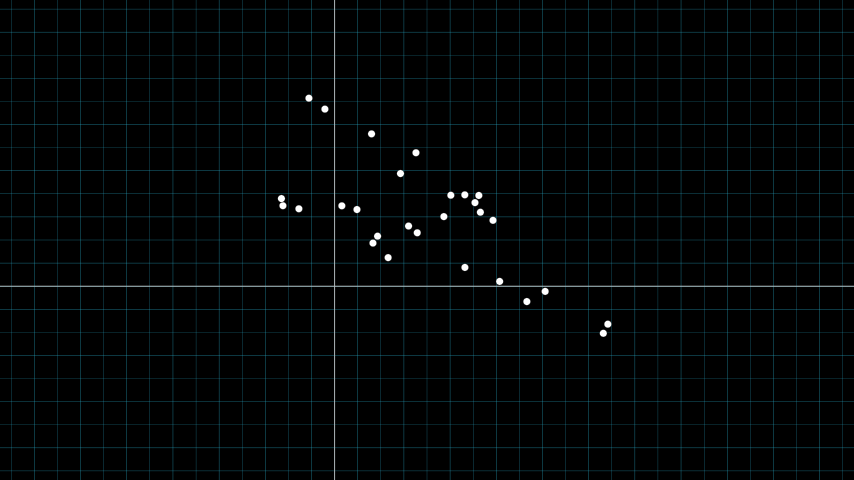

In [760]:
%%manim -ql -v warning -o points.png DisplayPoints
pass

Warm up with a simple projection: the data can be projected onto the first axis by zero-ing the second element of each data point. This is equivalent to projecting onto the vector (1, 0).

In [725]:
class DisplayProjectedX(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        self.add(*so.projection_lines)
        self.add(*so.vec_arrow)
        self.add(*so.vec_line)
        self.add(*so.dots)
        self.play(ProjectAndFadeAnim(so))
        self.wait()

In [726]:
%%manim -ql -v warning -o project-to-x.mp4 DisplayProjectedX
pass

And the data can be projected onto the the second axis by zero-ing the first element of each data point. This is equivalent to projecting onto the vector (0, 1).

In [656]:
class DisplayProjectedY(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data(starting_vec=np.array([0, 1]))
        self.add(*so.vec_arrow)
        vec_line = so.create_vec_line(include_numbers=False)
        vec_line.add_numbers(direction=manim.LEFT)
        self.add(*so.projection_lines)
        self.add(vec_line)
        self.add(*so.dots)
        #self.add(*so.dots_projected)
        #self.add(*so.vec_line)
        self.play(ProjectAndFadeAnim(so))
        self.wait()

In [657]:
%%manim -ql -v warning DisplayProjectedY
pass

<ipython-input-649-5d4e9e6fdfc0>:119: RuntimeWarning: divide by zero encountered in long_scalars
  line = manim.NumberLine(rotation=math.atan(self.scene_data.vec[1]/self.scene_data.vec[0]),


Below you can see all possible projections of the data onto a vector of unit length.

In [669]:
class RotateVectorAnim(manim.Animation):
    def __init__(self, scene_data, **kwargs):
        self.scene_data = scene_data
        super().__init__(None, run_time=8, rate_func=manim.rate_functions.linear, **kwargs)
        
    def update_mobjects(self, dt):
        v = self.scene_data.vec
        step = (dt * math.pi * 2)/self.run_time
        v_new = v @ np.array([[math.cos(step), math.sin(step)],
                              [-math.sin(step), math.cos(step)]])
        self.scene_data.update_vec(v_new) 
        
class AllUnitProjections(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        so.enable_dull_orig_dots(True)
        self.add(*so.projection_lines)
        self.add(*so.vec_arrow)
        self.add(*so.vec_line)
        self.add(*so.dots)
        self.add(*so.dots_projected)
        self.play(RotateVectorAnim(sd))

In [764]:
%%manim -ql -v warning -o allprojections.mp4 AllUnitProjections
pass

<ipython-input-763-e21baac3b6bb>:72: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  d.set_stroke_width(0.0)


Already you can spot some interesting projections. For example, below the vector is chosen so that the projected data points are spread out on the line. Indeed, this is the first vector calculated by principle component analysis, and thus, it is the vector that maximizes the variance of the data when it is projected onto a line. Principal components must be orthogonal, and as we are only in 2D, there can be only 2 principal components and the second one is perpendicular to the one we just found.

In [762]:
def create_pca_vec(data):
    pca = sk_dcomp.PCA()
    pca.fit(data)
    vec = pca.components_[0]
    vec = vec / np.linalg.norm(vec)
    return vec

class DisplayProjectedPCA(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        vec = create_pca_vec(generate_data())
        sd, so = create_data(starting_vec=vec)
        self.add(*so.vec_arrow)
        vec_line = so.create_vec_line(include_numbers=False)
        vec_line.add_numbers(direction=manim.LEFT)
        self.add(*so.projection_lines)
        self.add(vec_line)
        self.add(*so.dots)
        #self.add(*so.dots_projected)
        #self.add(*so.vec_line)
        self.play(ProjectAndFadeAnim(so))
        self.wait()

In [755]:
%%manim -ql -v warning -o pca.mp4 DisplayProjectedPCA
pass

If we replay the previous video from the perspective we see the following:

In [718]:
_temp_camera = None
class SyncCameraRotation(manim.Animation):
    def __init__(self, scene, scene_data, **kwargs):
        self.scene_data = scene_data
        self.scene = scene
        super().__init__(None, run_time=8, rate_func=manim.rate_functions.linear, **kwargs)
        
    def update_mobjects(self, dt):
        v = self.scene_data.vec
        step = (dt * math.pi * 2)/self.run_time
        v_new = v @ np.array([[math.cos(step), math.sin(step)],
                              [-math.sin(step), math.cos(step)]])
        self.scene_data.update_vec(v_new) 
        #self.scene.camera.theta_tracker += step #+ math.pi/2
        
class AllProjectionsLinePerspective(manim.ThreeDScene):
    def construct(self):
        plane = setup_plane(self)
        sd, so = create_data()
        self.add(*so.projection_lines)
        self.add(*so.vec_arrow)
        self.add(*so.vec_line)
        self.add(*so.dots)
        self.add(*so.dots_projected)
        #combo_anim = manim.AnimationGroup(None, )
        camera_rotate_anim = manim.ApplyMethod(self.renderer.camera.theta_tracker.set_value)
        
        self.move_camera(theta=2*math.pi + (-math.pi/2), run_time=8, rate_func=manim.rate_functions.linear,
                        added_anims=[SyncCameraRotation(self, sd)])#, added_anims=[SyncCameraRotation(sd)])
        #self.wait(2)
        #self.play(SyncCameraRotation(self, sd))
        #self.wait(1)

In [719]:
%%manim -ql -o all-projections-line-perspective.mp4 AllProjectionsLinePerspective
pass